In [21]:
import hsup as _
import gymnasium as gym
from stable_baselines3 import PPO, DDPG
import torch
import numpy as np

from dataset.data import data
from dataset.simulation import model_indoor, model_sec_back_t

In [22]:
SEED = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)


In [25]:
TOTAL_TIMESTEPS = 5e4
LOG_INTERVAL = 100

env = gym.make(
    "hsup/HeatSupply-v0",
    max_episode_steps=24,

    data=data,
    model_indoor=model_indoor,
    model_sec_back_t=model_sec_back_t,
)

In [ ]:
model = DDPG("MlpPolicy", env, verbose=1, tensorboard_log="./runs", seed=42)
model.learn(total_timesteps=TOTAL_TIMESTEPS, progress_bar=True, log_interval=LOG_INTERVAL)
model.save(f"checkpoints/ddpg-{TOTAL_TIMESTEPS}")


/home/yanglsh/miniconda3/envs/rl/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:364: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


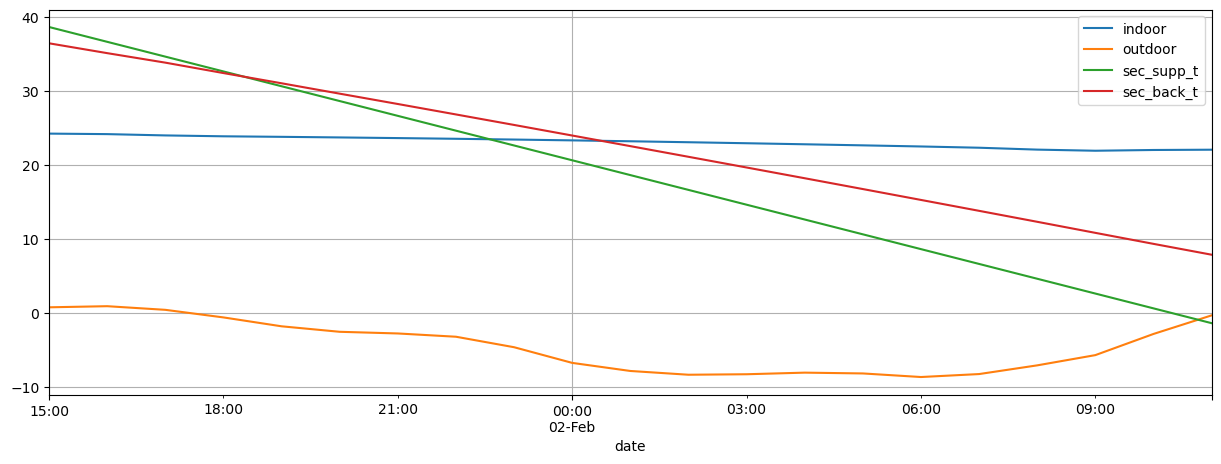

In [27]:
model = DDPG.load(f"checkpoints/ddpg-{TOTAL_TIMESTEPS}")

obs, _ = env.reset()
while True:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, trunc, _ = env.step(action)
    if trunc or done:
        break
    
env.render()